# Attention Deficit Disorder Detection

## Unzip data

In [2]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Medical/ADHD_CONTROL/datasets/ADHD_DATA.zip"

## Download Helper Function

In [3]:
%%capture
! wget https://raw.githubusercontent.com/HSAkash/Attention-Deficit-Disorder-Detection/main/helper_functions.py

## Install packages

In [4]:
! pip install mne
from IPython import display
display.clear_output()
import mne
mne.__version__

'1.4.2'

## Gdrive path

In [5]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Medical/ADHD_CONTROL"

## Import dependencies

In [6]:
from glob import glob
import scipy.io
import numpy as np
import mne
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tqdm.auto import tqdm

np.random.seed(42)

## Import helper function

In [7]:
from helper_functions import (
    plot_loss_curves,
    create_tensorboard_callback,
    History,
    make_confusion_matrix
)

## Get Prescision, Recall, F1 Score

In [36]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

def getPrescisionRecallF1(y_true, y_pred, title):
    # Example confusion matrix (replace with your own values)
    confusion = confusion_matrix(y_true, y_pred)

    # Calculate precision for each class
    precision = np.diagonal(confusion) / np.sum(confusion, axis=0)

    # Calculate recall for each class
    recall = np.diagonal(confusion) / np.sum(confusion, axis=1)

    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate accuracy
    accuracy = np.zeros(2)
    accuracy[0] = confusion[0][0]/sum(confusion[0])
    accuracy[1] = confusion[1][1]/sum(confusion[1])

    # Calculate overall metrics by averaging values across all classes
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    avg_acuracy = accuracy_score(y_true, y_pred)

    header = f"""{'Metrics':^10}    {'Control':^10}    {'ADHD':^10}    {'Average':^10}"""
    print(f"_________________{title}______________________\n")
    print(header)
    print(f"""{'_'*len(header)}""")
    print(f"""{'Precision':^10}    {precision[0]:^10.4f}    {precision[1]:^10.4f}    {avg_precision:^10.4f}""")
    print(f"""{'Recall':^10}    {recall[0]:^10.4f}    {recall[1]:^10.4f}    {avg_recall:^10.4f}""")
    print(f"""{'F1 Score':^10}    {f1[0]:^10.4f}    {f1[1]:^10.4f}    {avg_f1:^10.4f}""")
    print(f"""{'Accuracy':^10}    {accuracy[0]:^10.4f}    {accuracy[1]:^10.4f}    {avg_acuracy:^10.4f}""")


## Mat data mne

In [9]:
mne.set_log_level("WARNING")
def convertmat2mne_60(data):
    ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
    ch_types = ['eeg'] * 19
    sampling_freq=128
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq, verbose=0)
    info.set_montage('standard_1020', verbose=0)
    data = np.moveaxis(data, 0, -1)
    data=mne.io.RawArray(data, info, verbose=0)
    data.set_eeg_reference(verbose=0)
    # data.filter(l_freq=1,h_freq=35)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0, verbose=0)
    # return np.moveaxis(epochs.get_data(), 1, -1)
    return epochs.get_data()

In [10]:
def convertmat2mne_30(data):
    ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
    ch_types = ['eeg'] * 19
    sampling_freq=128
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq, verbose=0)
    info.set_montage('standard_1020', verbose=0)
    data = np.moveaxis(data, 0, -1)
    data=mne.io.RawArray(data, info, verbose=0)
    data.set_eeg_reference(verbose=0)
    data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0, verbose=0)
    # return np.moveaxis(epochs.get_data(), 1, -1)
    return epochs.get_data()

In [11]:
def get_mne_dataset_60(list_path):
    dataset = []
    for x in tqdm(list_path):
        data = scipy.io.loadmat(x)[x.split('/')[-1].split('.')[0]]
        data = convertmat2mne_60(data)
        dataset.append(data)
    return dataset

def get_mne_dataset_30(list_path):
    dataset = []
    for x in tqdm(list_path):
        data = scipy.io.loadmat(x)[x.split('/')[-1].split('.')[0]]
        data = convertmat2mne_30(data)
        dataset.append(data)
    return dataset

## Get label

In [12]:
# /kaggle/input/adhd-mat-dataset/dataset/ADHD/v10p.mat
labels_dict = {"ADHD":1, "Control":0}
def get_label(filePath):
    return labels_dict[filePath.split("/")[-2]]

## Data path

In [13]:
data_dir = "ADHD_DATA"

## Get all file path

In [14]:
filePath_list = glob(f"{data_dir}/*/*.mat")
len(filePath_list)

121

## Shuffle filepath list

In [ ]:
import sklearn
filePath_list = sklearn.utils.shuffle(filePath_list, random_state=0)

## Get labels

In [16]:
labels_list = [get_label(x) for x in filePath_list]
len(labels_list)

121

## get data

In [52]:
data_list_60 = get_mne_dataset_60(filePath_list)
data_list_30 = get_mne_dataset_30(filePath_list)
len(data_list_60), len(data_list_30)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

(121, 121)

## Get labels

In [18]:
label_list, groups_list = [], []
for i, data in enumerate(data_list_60):
    label_list.append([labels_list[i]]*len(data))
    groups_list.append([i]*len(data))

## List to numpy

In [19]:
data_array_60=np.concatenate(data_list_60)
data_array_30=np.concatenate(data_list_30)
label_array=np.concatenate(label_list)
group_array=np.concatenate(groups_list)

data_array_60=np.moveaxis(data_array_60,1,2)
data_array_30=np.moveaxis(data_array_30,1,2)

del(data_list_60)
del(data_list_30)
del(label_list)
del(groups_list)

data_array_60.shape, data_array_30.shape

((4173, 512, 19), (4173, 512, 19))

## Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()
        # self.scaler = MinMaxScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)

## Spliting data

In [21]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
gkf=GroupKFold()
for train_index, val_index in gkf.split(data_array_60, label_array, groups=group_array):

    train_features_60,train_labels=data_array_60[train_index],label_array[train_index]
    val_features_60,val_labels=data_array_60[val_index],label_array[val_index]

    scaler_60=StandardScaler3D()
    train_features_60=scaler_60.fit_transform(train_features_60)
    val_features_60=scaler_60.transform(val_features_60)


    train_features_30=data_array_30[train_index]
    val_features_30=data_array_30[val_index]

    scaler_30=StandardScaler3D()
    train_features_30=scaler_30.fit_transform(train_features_30)
    val_features_30=scaler_30.transform(val_features_30)


    break

## Create model


### Import dependencies

In [ ]:
from tensorflow.keras.layers import Input,Dense,Flatten,GRU,Conv1D, Concatenate, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf
tf.random.set_seed(42)

### Create  check points

In [ ]:
checkpoint_path = f"{gdrive_Path}/14_crononet/10/checkpoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)
tensorboard_dir = f"{gdrive_Path}/14_crononet/10/tensorboard"
tensorboard_name = 'ADHD_model'
checkpoint_path

'checkpoint/cp.ckpt'

### Modeling

In [ ]:
def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=-1)
  return x

#### Model part1

In [ ]:
input_60= Input(shape=train_features_60.shape[1:])
block1_60=block(input_60)
block2_60=block(block1_60)
block3_60=block(block2_60)
gru_out1_60 = GRU(32,activation='tanh',return_sequences=True)(block3_60)
gru_out2_60 = GRU(32,activation='tanh',return_sequences=True)(gru_out1_60)
gru_out_60 = concatenate([gru_out1_60,gru_out2_60],axis=-1)
gru_out3_60 = GRU(32,activation='tanh',return_sequences=True)(gru_out_60)
gru_out_60 = concatenate([gru_out1_60,gru_out2_60,gru_out3_60])
gru_out4_60 = GRU(32,activation='tanh')(gru_out_60)
gru_out4_60.shape

TensorShape([None, 32])

#### Model part2

In [ ]:
input_30= Input(shape=train_features_30.shape[1:])
block1_30=block(input_30)
block2_30=block(block1_30)
block3_30=block(block2_30)
gru_out1_30 = GRU(32,activation='tanh',return_sequences=True)(block3_30)
gru_out2_30 = GRU(32,activation='tanh',return_sequences=True)(gru_out1_30)
gru_out_30 = concatenate([gru_out1_30,gru_out2_30],axis=-1)
gru_out3_30 = GRU(32,activation='tanh',return_sequences=True)(gru_out_30)
gru_out_30 = concatenate([gru_out1_30,gru_out2_30,gru_out3_30])
gru_out4_30 = GRU(32,activation='tanh')(gru_out_30)
gru_out4_30.shape

TensorShape([None, 32])

#### Combine two model

In [ ]:
combine = concatenate([gru_out4_60,gru_out4_30])
combine.shape

TensorShape([None, 64])

In [ ]:
output = Dense(1,activation='sigmoid')(combine)
model = Model(inputs=[input_60, input_30], outputs=output)

#### Compile model

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Summary model

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 19)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512, 19)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 256, 32)      1248        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 256, 32)      2464        ['input_1[0][0]']                
                                                                                              

### Ploting model

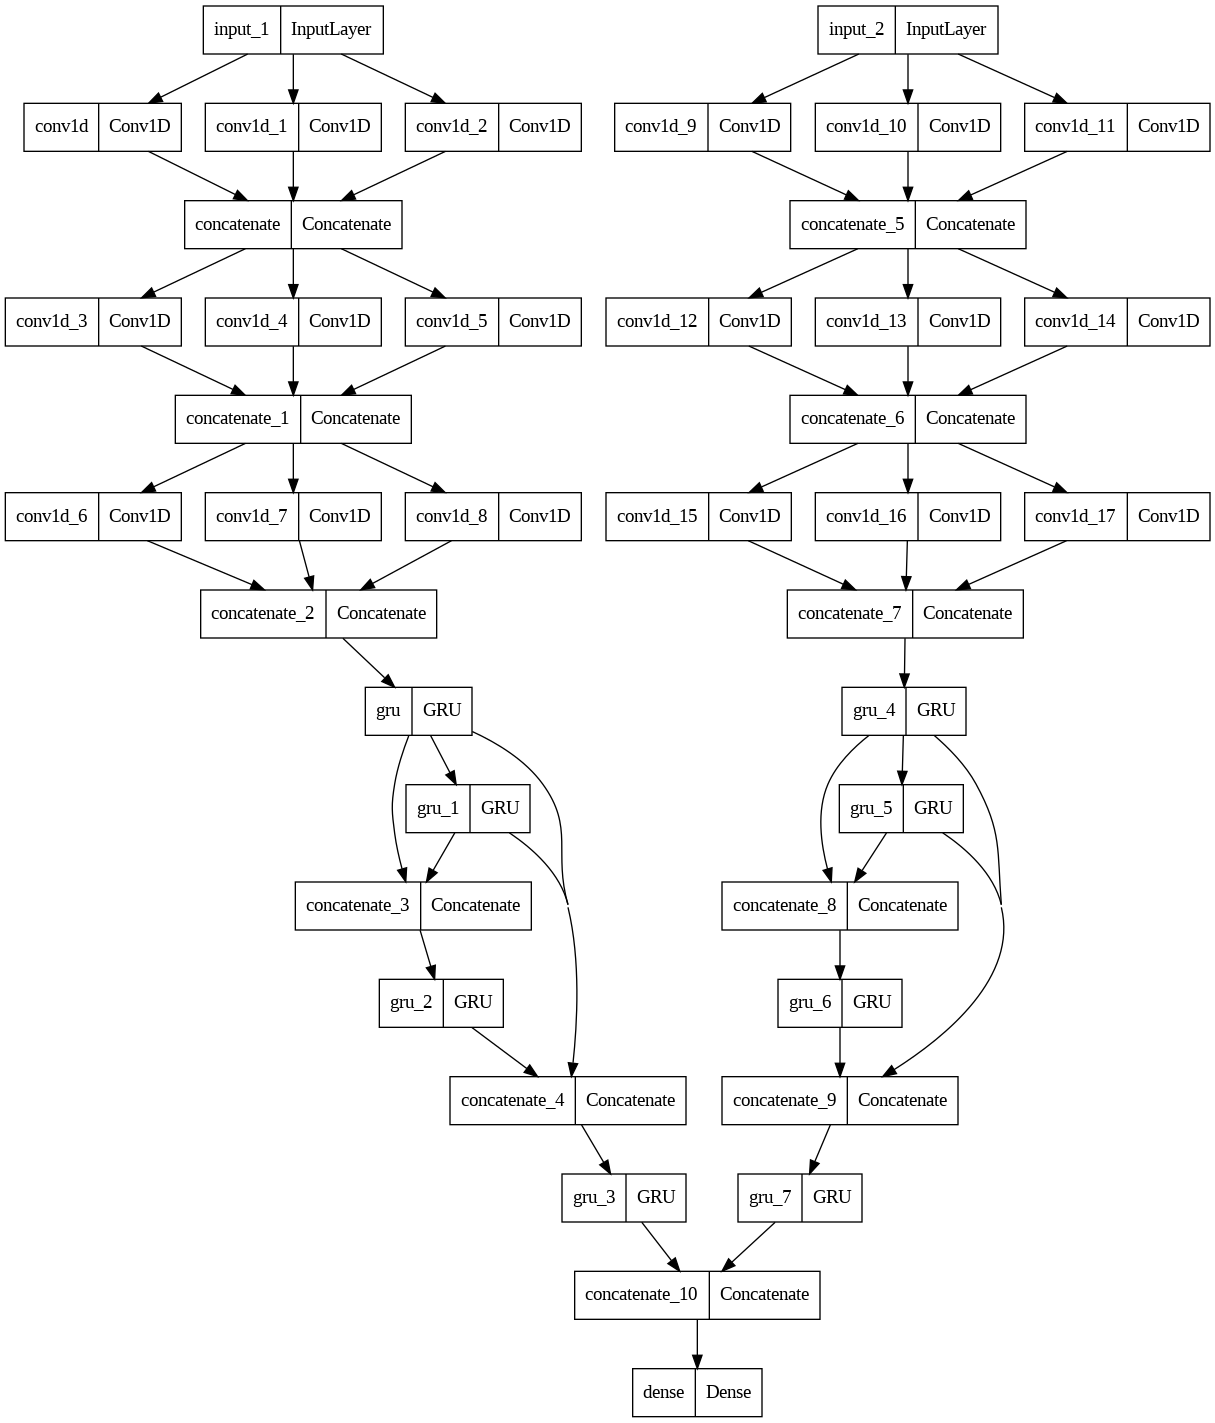

In [ ]:
tf.keras.utils.plot_model(model)

### Fit the model epoch 10

In [ ]:
history = model.fit(
    [train_features_60, train_features_30],
    train_labels,
    validation_data = ([val_features_60, val_features_30], val_labels),
    epochs=10,
    batch_size=128,
    callbacks = [
        create_tensorboard_callback(
            dir_name = tensorboard_dir,
            experiment_name = tensorboard_name
        ),
        checkpoint_callback
    ]
)
histories = History(history)

Saving TensorBoard log files to: tensorboard/ADHD_model/20230330-060348
Epoch 1/10
27/27 [==============================] - 64s 1s/step - loss: 0.6521 - accuracy: 0.6157 - val_loss: 0.5890 - val_accuracy: 0.7163
Epoch 2/10
27/27 [==============================] - 35s 1s/step - loss: 0.3803 - accuracy: 0.8399 - val_loss: 0.3388 - val_accuracy: 0.8522
Epoch 3/10
27/27 [==============================] - 33s 1s/step - loss: 0.1936 - accuracy: 0.9267 - val_loss: 0.1686 - val_accuracy: 0.9267
Epoch 4/10
27/27 [==============================] - 34s 1s/step - loss: 0.0970 - accuracy: 0.9665 - val_loss: 0.3338 - val_accuracy: 0.8678
Epoch 5/10
27/27 [==============================] - 34s 1s/step - loss: 0.0255 - accuracy: 0.9946 - val_loss: 0.3295 - val_accuracy: 0.8894
Epoch 6/10
27/27 [==============================] - 36s 1s/step - loss: 0.0121 - accuracy: 0.9973 - val_loss: 0.5338 - val_accuracy: 0.8606
Epoch 7/10
27/27 [==============================] - 36s 1s/step - loss: 0.0077 - accurac

### Plot model loss curves

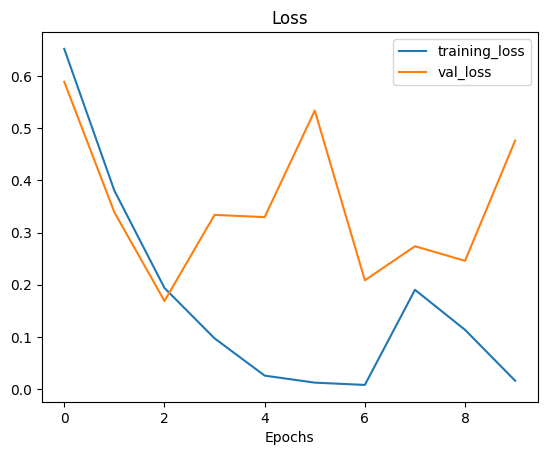

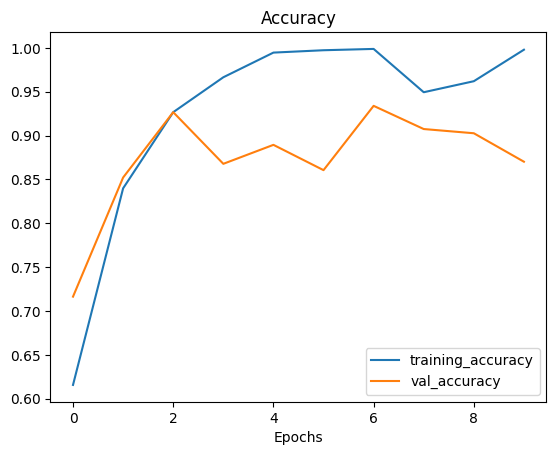

In [ ]:
plot_loss_curves(histories)

### Evaluate

#### Evaluate model

In [ ]:
model.evaluate([val_features_60, val_features_30], val_labels)

26/26 [==============================] - 4s 146ms/step - loss: 0.4764 - accuracy: 0.8702


[0.4763686954975128, 0.870192289352417]

#### Copy Model and load best weight

In [ ]:
best_model = tf.keras.models.clone_model(model)
best_model.load_weights(checkpoint_path)
best_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

#### Evalute best model

In [ ]:
best_model.evaluate([train_features_60, train_features_30], train_labels), best_model.evaluate([val_features_60, val_features_30], val_labels)

26/26 [==============================] - 2s 85ms/step - loss: 0.2083 - accuracy: 0.9339


([0.024994324892759323, 0.9907213449478149],
 [0.2082936018705368, 0.9338942170143127])

### Confusion matrix

#### Prediction

In [22]:
best_model = tf.keras.models.load_model(f"/content/drive/MyDrive/Colab Notebooks/Medical/ADHD_CONTROL/05_For_Paper/save_models/pretrain_model.h5")

In [29]:
best_model.evaluate([val_features_60, val_features_30], val_labels)

26/26 [==============================] - 5s 48ms/step - loss: 0.2083 - accuracy: 0.9339


[0.2082936018705368, 0.9338942170143127]

#### Val data conf matrix

In [23]:
val_y_pred = best_model.predict([val_features_60, val_features_30], verbose=0)

In [24]:
val_y_pred = np.squeeze(np.where(val_y_pred >= 0.5, 1, 0), axis=-1)

In [30]:
confusion = confusion_matrix(val_labels, val_y_pred)
confusion

array([[263,  19],
       [ 36, 514]])

#### Print Prescision, Recall, F1 Score & Accuracy

In [37]:
getPrescisionRecallF1(val_labels, val_y_pred, "4 sec Sample validation")

_________________4 sec Sample validation______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       0.8796        0.9644        0.9220  
  Recall        0.9326        0.9345        0.9336  
 F1 Score       0.9053        0.9492        0.9273  
 Accuracy       0.9326        0.9345        0.9339  


#### Plot confusion matrix


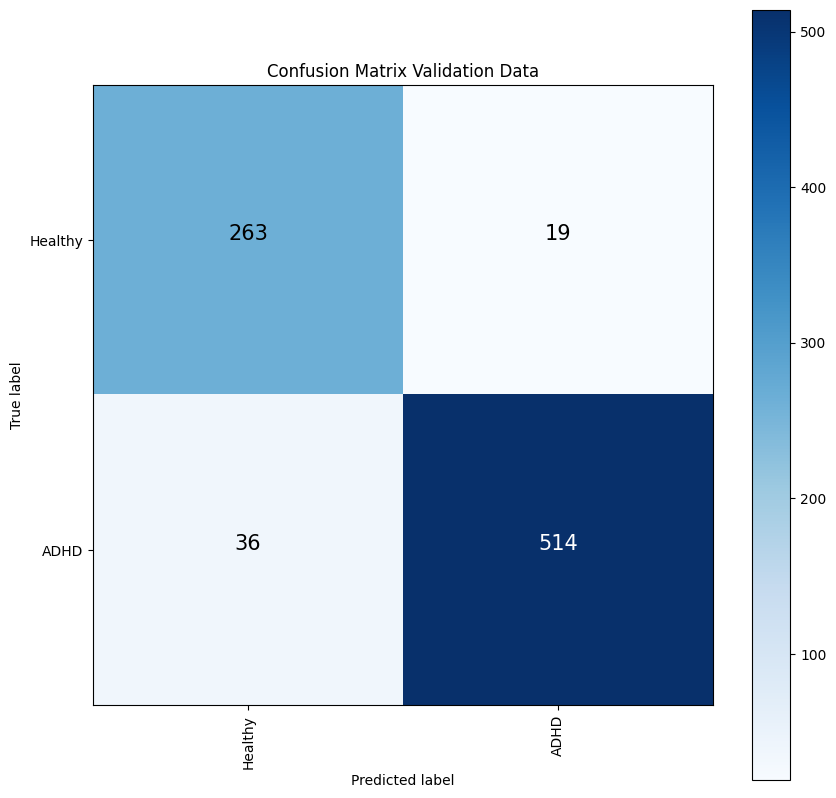

In [ ]:
make_confusion_matrix(val_labels, val_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix Validation Data")

#### train data conf matrix

In [34]:
train_y_pred = best_model.predict([train_features_60, train_features_30], verbose=0)
train_y_pred = np.squeeze(np.where(train_y_pred >= 0.5, 1, 0), axis=-1)

#### Print Prescision, Recall, F1 Score & Accuracy

In [38]:
getPrescisionRecallF1(train_labels, train_y_pred, "4 sec Sample training")

_________________4 sec Sample training______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       1.0000        0.9829        0.9914  
  Recall        0.9801        1.0000        0.9901  
 F1 Score       0.9900        0.9914        0.9907  
 Accuracy       0.9801        1.0000        0.9907  


#### Plot confusion matrix

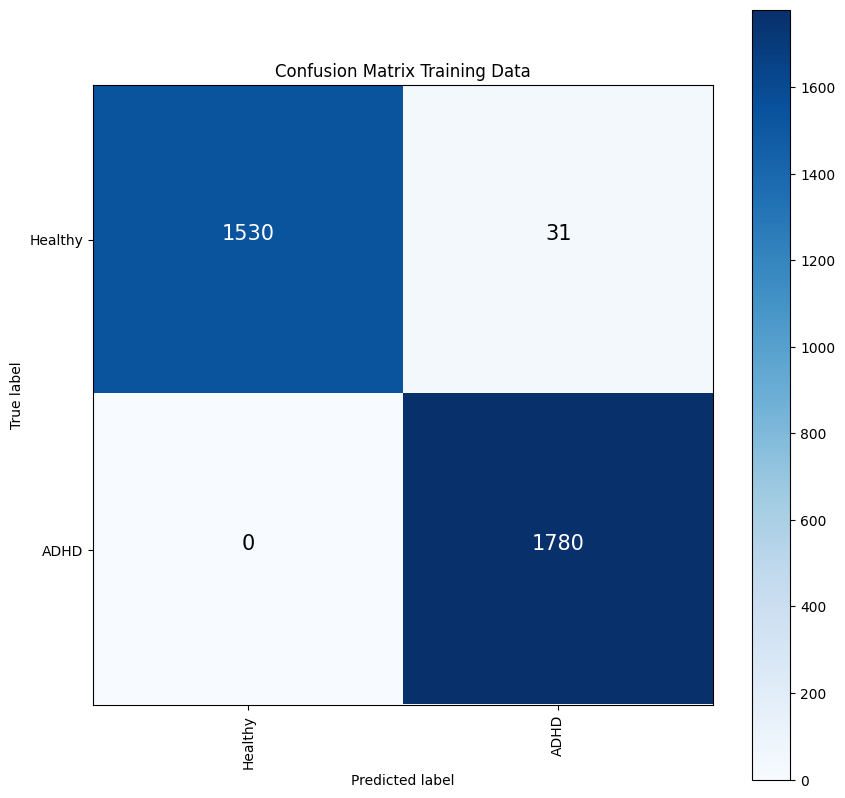

In [ ]:
make_confusion_matrix(train_labels, train_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix Training Data")

#### Full data conf matrix

In [40]:
full_data_60 = np.concatenate([train_features_60, val_features_60], axis=0)
full_data_30 = np.concatenate([train_features_30, val_features_30], axis=0)
full_label = np.concatenate([train_labels, val_labels])

In [41]:
full_y_pred = best_model.predict([full_data_60, full_data_30], verbose=0)
full_y_pred = np.squeeze(np.where(full_y_pred >= 0.5, 1, 0), axis=-1)

#### Print Prescision, Recall, F1 Score & Accuracy

In [42]:
getPrescisionRecallF1(full_label, full_y_pred, "4 sec Sample total")

_________________4 sec Sample total______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       0.9803        0.9787        0.9795  
  Recall        0.9729        0.9845        0.9787  
 F1 Score       0.9766        0.9816        0.9791  
 Accuracy       0.9729        0.9845        0.9794  


#### Plot confusion matrix

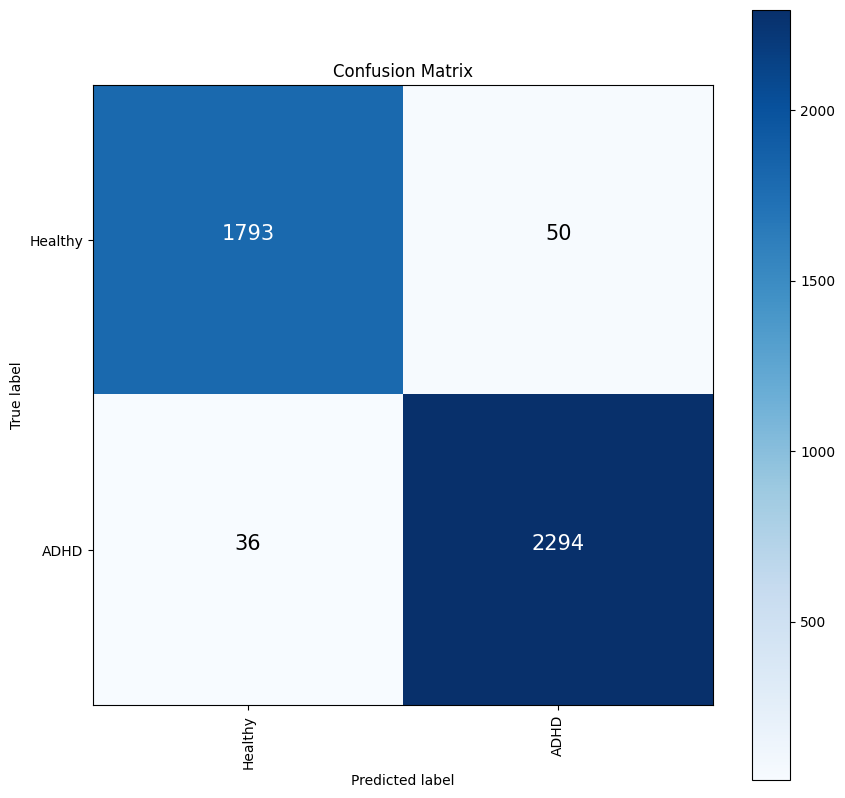

In [ ]:
make_confusion_matrix(full_label, full_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix")

### Save best model

In [ ]:
best_model.save(f"{gdrive_Path}/save_models/best_model.h5")

### Save Scaler model

In [ ]:
joblib.dump(scaler_60, f'{gdrive_Path}/save_models/scaler_60.save')
joblib.dump(scaler_30, f'{gdrive_Path}/save_models/scaler_30.save')

## Voiting


### Load pretrain model and data
* Load best_model.h5
* Load Scaler model


In [ ]:
load_model = tf.keras.models.load_model(f"{gdrive_Path}/save_models/pretrain_model.h5")

In [ ]:
scaler_60 = joblib.load(f'{gdrive_Path}/save_models/scaler_60.save')
scaler_30 = joblib.load(f'{gdrive_Path}/save_models/scaler_30.save')

### Taking 20% for validation
* Total person 121
* Training purpose person 97
* Validation purpose person 24

In [44]:
train_files = filePath_list[np.unique(group_array[train_index])]
y_train = np.array([get_label(x) for x in train_files])

val_files = filePath_list[np.unique(group_array[val_index])]
y_val = np.array([get_label(x) for x in val_files])

train_files.shape, val_files.shape

((97,), (24,))

### File to mne dataset

In [45]:
X_train_60_list =  get_mne_dataset_60(train_files)
X_train_30_list =  get_mne_dataset_30(train_files)

X_val_60_list =  get_mne_dataset_60(val_files)
X_val_30_list =  get_mne_dataset_30(val_files)

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

### Voiting

In [46]:
def Voting(model, X_60_data, X_30_data, y_true):
    voit = np.zeros((2,2))
    return_y_pred = []
    for i in tqdm(range(len(y_true))):
        X_60 = X_60_data[i]
        X_30 = X_30_data[i]

        X_60 = np.moveaxis(X_60,1,2)
        X_30 = np.moveaxis(X_30,1,2)

        X_60 = scaler_60.transform(X_60)
        X_30 = scaler_30.transform(X_30)

        y_preds = model.predict((X_60, X_30), verbose=0)
        y_preds = np.squeeze(np.where(y_preds >= 0.5, 1, 0), axis=-1)

        y_pred = np.argmax(np.bincount(y_preds))
        y = y_true[i]
        voit[y,y_pred] += 1

        return_y_pred.append(y_pred)
    return voit, np.array(return_y_pred)

### Validation data set Evaluation
* Get confusion metrics.
* Get Prescision, Recall & F1 Score
* Plot Confusion metrics
```
24 person data took for validation.
```

#### Get confusion matrix & predicted value

In [47]:
val_vote, val_y_pred  = Voting(load_model, X_val_60_list, X_val_30_list, y_val)
val_vote

  0%|          | 0/24 [00:00<?, ?it/s]

array([[ 8.,  1.],
       [ 0., 15.]])

#### Print Prescision, Recall & F1 Score

In [48]:
getPrescisionRecallF1(y_val, val_y_pred, title = "validation")

_________________validation______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       1.0000        0.9375        0.9688  
  Recall        0.8889        1.0000        0.9444  
 F1 Score       0.9412        0.9677        0.9545  
 Accuracy       0.8889        1.0000        0.9583  


#### Plot Confusion matrix

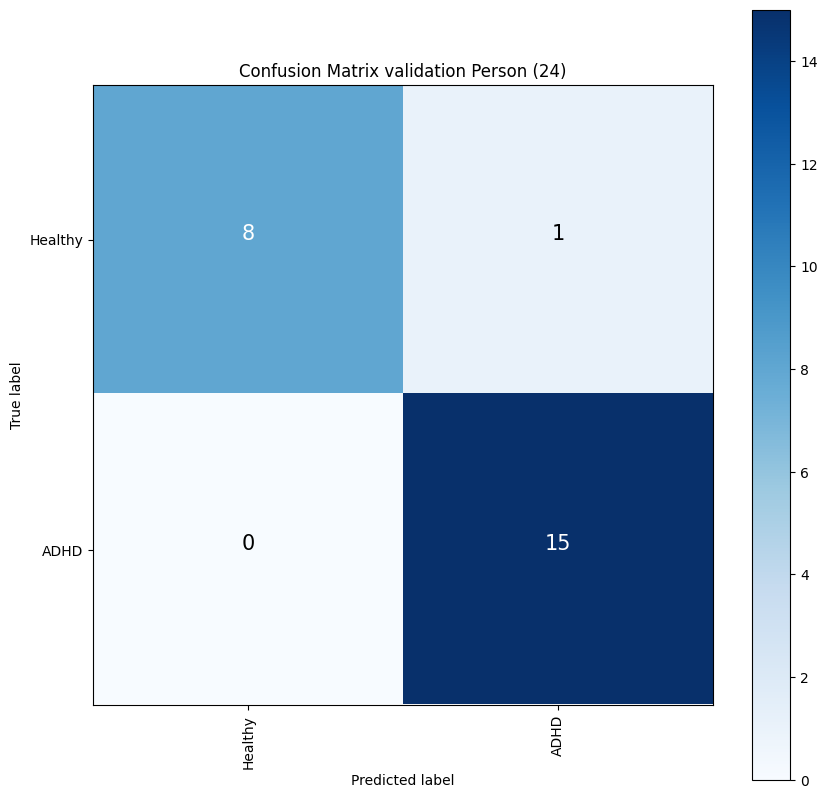

In [ ]:
make_confusion_matrix(y_val, val_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix validation Person (24)")

### Training data set Evaluation
* Get confusion metrics.
* Get Prescision, Recall & F1 Score
* Plot Confusion metrics
```
97 person data took for Training.
```

#### Get confusion matrix & predicted value

In [49]:
train_vote, train_y_pred = Voting(load_model, X_train_60_list, X_train_30_list, y_train)
train_vote

  0%|          | 0/97 [00:00<?, ?it/s]

array([[51.,  0.],
       [ 0., 46.]])

#### Print Prescision, Recall & F1 Score

In [50]:
getPrescisionRecallF1(y_train, train_y_pred, title = "Training")

_________________Training______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       1.0000        1.0000        1.0000  
  Recall        1.0000        1.0000        1.0000  
 F1 Score       1.0000        1.0000        1.0000  
 Accuracy       1.0000        1.0000        1.0000  


#### Plot Confusion matrix

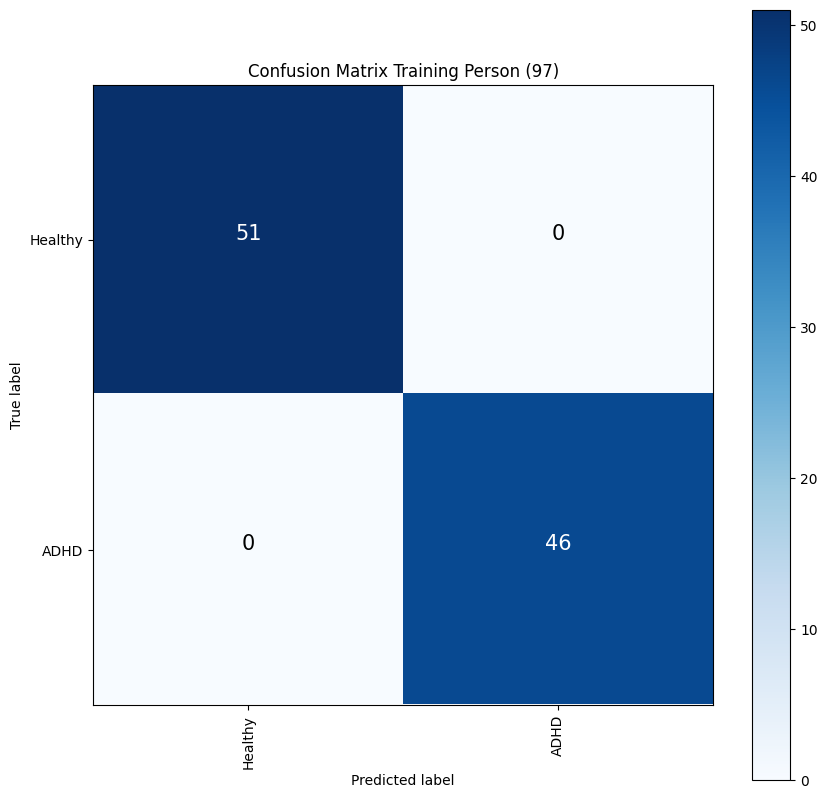

In [ ]:
make_confusion_matrix(y_train, train_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix Training Person (97)")

### Total dataset Evaluation
* Get confusion metrics.
* Get Prescision, Recall & F1 Score
* Plot Confusion metrics
```
Total 121 person dataset evaluate
```

#### Get confusion matrix & predicted value

In [53]:
total_vote, total_y_pred =  Voting(load_model, data_list_60, data_list_30, labels_list)
total_vote

  0%|          | 0/121 [00:00<?, ?it/s]

array([[59.,  1.],
       [ 0., 61.]])

#### Print Prescision, Recall, F1 Score & Accuracy

In [54]:
getPrescisionRecallF1(labels_list, total_y_pred, title = "Total")

_________________Total______________________

 Metrics       Control         ADHD        Average  
____________________________________________________
Precision       1.0000        0.9839        0.9919  
  Recall        0.9833        1.0000        0.9917  
 F1 Score       0.9916        0.9919        0.9917  
 Accuracy       0.9833        1.0000        0.9917  


#### Plot Confusion matrix

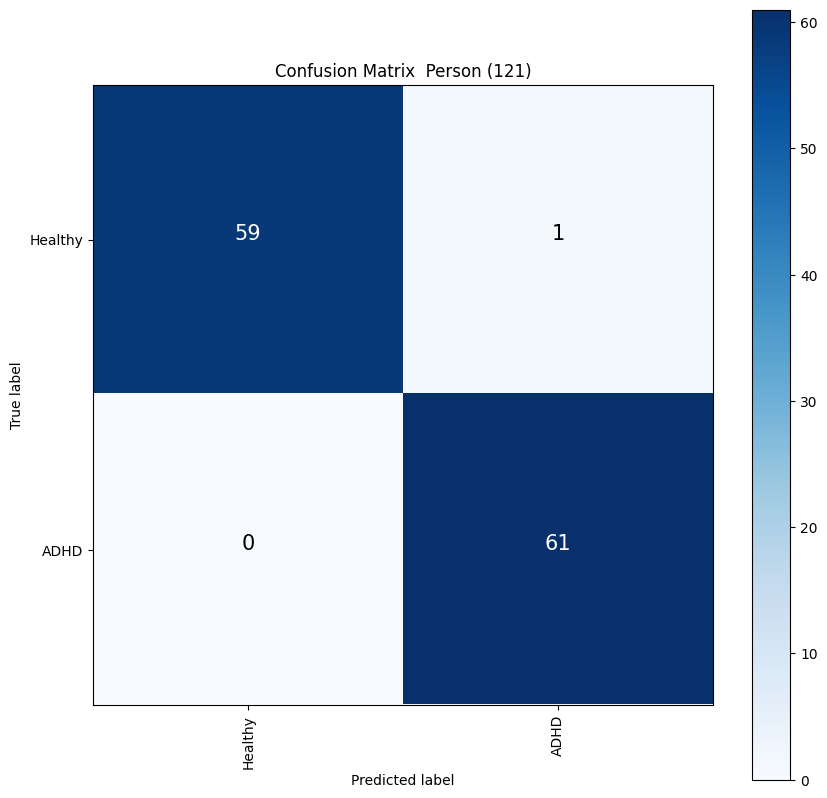

In [ ]:
make_confusion_matrix(labels_list, total_y_pred, ["Healthy", "ADHD"], title="Confusion Matrix  Person (121)")